In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
import math
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import solve_ivp
from numpy.fft import fft, ifft, fftfreq, rfft, irfft, rfft2, irfft2, fft2, ifft2
from scipy.fftpack import diff as psdiff
from sympy import *
from numpy import pi,fliplr,concatenate

In [2]:
nr = 1000 # number of computational grids
nz = 1000
h =2/nr # spacing of computational grid [m]
e = 0.03 # interfacial thickness [m]

In [3]:
cy=np.zeros((nz,nr))
for i in range(nr):
  cy[:,i]=np.ones(nz)*(i+0.5)

In [4]:
simpson=np.ones((nz,nr))
for i in range(nz):
    for j in range(nr):
        if i==0 or i==nr-1:
            ki=1
        elif i%2==0 and i!=nr-1:
            ki=2
        else:
            ki=4
        if j==0 or j==nz-1:
            kj=1
        elif j%2==0 and j!=nz-1:
            kj=2
        else:
            kj=4
        simpson[i,j]=simpson[i,j]*ki*kj

In [5]:
mr = int(nr+1)
mz = int(nz/2+1)
kr=fftfreq(mr)*mr*2*pi/(2*h*nr)
kz=fftfreq(mz)*mz*2*pi/(h*nz)
filter_r=np.ones((nz,mr))
filter_r[:,int(2*mr/3):]=0
filter_z=np.ones((mz,nr))
filter_z[int(2*mz/3):,:]=0

In [6]:
def aliasing(u):
    u=complete(u)
    uw_r=rfft2(u,axes=(-2,-1))
    uw_r_f=uw_r*filter_r
    u_r_f=irfft2(uw_r_f,axes=(-2,-1))[:,:nr]

    uw_z=rfft2(u_r_f,axes=(-1,-2))
    uw_z_f=uw_z*filter_z
    u_f=irfft2(uw_z_f,axes=(-1,-2))
    return u_f

In [7]:
u0 = np.zeros((nz, nr))
for i in range(nz):
    for j in range(nr):
        r = np.sqrt((i*h-1)**2+((j+0.5)*h)**2)
        u0[i,j] = (np.tanh((0.6404-r)/(np.sqrt(2)*e)))

In [8]:
def complete(f):
  f_r=np.fliplr(f)
  f_c=concatenate([f,f_r],1)
  return f_c

In [9]:
class derivative:

    def __init__(self,u):
        self.u=u
        self.c=complete(u)
        self.ftr=rfft2(self.c,axes=(-2,-1))
        self.ftz=rfft2(self.u,axes=(-1,-2))


    def dr(self):
        fr_c=irfft2(1.0j*kr*self.ftr,axes=(-2,-1))
        fr=fr_c[:,:nr]
        return fr

    def dz(self):
        ftz=self.ftz
        fz=irfft2(1.0j*ftz*np.array([kz]).T,axes=(-1,-2))
        return fz
    
    def drr(self):
        ftrr=self.ftr
        ffr_c=irfft2(ftrr*(1.0j*kr)**2)
        frr=ffr_c[:,:nr]
        return frr

    def dzz(self):
        ftzz=self.ftz
        fzz=irfft2(ftzz*(1.0j*np.array([kz]).T)**2,axes=(-1,-2))
        return fzz

In [10]:
initial=derivative(u0)
dr=initial.dr()
dz=initial.dz()
drr=initial.drr()
dzz=initial.dzz()

In [11]:
class property:
    def __init__(self,u,dru,dzu):
        self.u=u
        self.dr=dru
        self.dz=dzu
    def V(self):
        v=0.5*(1+self.u)*cy*simpson
        V=np.sum(v)*(h**3)*pi*2/9
        return V

    def S(self):
        gf2=self.dr**2+self.dz**2
        b=e*gf2/2+(self.u**2-1)**2/(4*e)
        s=cy*b*simpson
        S=np.sum(s)*(h**3)*3/(2*np.sqrt(2))*pi*2/9
        return S

In [12]:
restrain=property(u0,dr,dz)
V0=restrain.V()
S0=restrain.S()

In [13]:
print(V0,S0)

1.1120362084038724 5.160909145273159


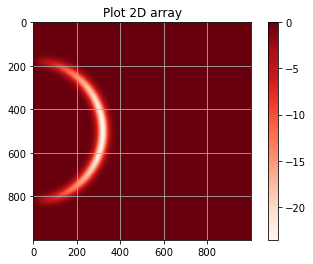

In [14]:
X=dr
fig = plt.figure()
plt.imshow(X,cmap="Reds")
plt.title("Plot 2D array")
plt.grid()
#plt.xticks(np.arange(0, ny, step=ny/10))
#plt.yticks(np.arange(0, nx, step=nx/10))
plt.colorbar()
plt.show()

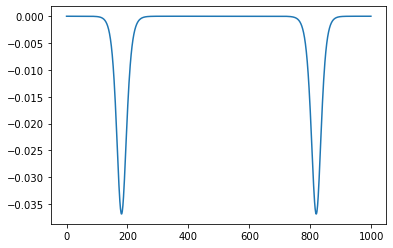

In [15]:
plt.plot(dr[:,0])

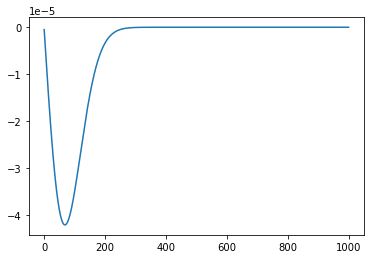

In [16]:
plt.plot(dr[50,:])

In [17]:
def c_laplacian(f):
    initial=derivative(f)
    dr=initial.dr()
    drr=initial.drr()
    dzz=initial.dzz()
    clu=drr+dzz+dr/cy
    return clu

In [18]:
class energy:

    def __init__(self,u,V,S):
        self.u=u
        self.V=V
        self.S=S
        self.ru=c_laplacian(u)

    def E(self):
        dE=k*e*(self.ru+(self.u-self.u**3)/e**2)**2/2
        E=np.sum(dE*cy*simpson)*(h**3)*2*pi/9 +M1*(self.V-alpha)**2/2+M2*(self.S-beta)**2/2
        return E

    def gfE(self):
        r2u=c_laplacian(self.ru)
        ru3=c_laplacian(self.u**3)
        dE=k*(e*r2u+(1-3*self.u**2)*self.ru/e+(self.u-self.u**3)*(1-3*self.u**2)/(e**3)-(ru3-self.ru)/e)
        A=(self.V-alpha)*0.5
        B=(self.S-beta)*((self.u**3-self.u)/e-self.ru*e)
        dEh=dE+M1*A+M2*B
        return dEh

In [19]:
M1=100000
M2=100000
alpha= 1.11
beta= 7.0004
k = 1 # bending rigidcy
c0 = 0

In [20]:
EBE0=energy(u0,V0,S0)
E_0=EBE0.E()

In [21]:
print(E_0)

169192.48509412378


In [22]:
def foward_eular(u0,nsteps,dt0):
    u=u0
    dt=dt0

    U=[]
    E=[]
    T=[]
    U_append = U.append
    E_append = E.append
    T_append = T.append

    

    for t in range(nsteps):
        der=derivative(u)
        dr,dz=der.dr(),der.dz()

        restrain=property(u,dr,dz)
        V,S=restrain.V(),restrain.S()

        EBE=energy(u,V,S)
        E_o,dEh=EBE.E(),EBE.gfE()
        
        origin=u-dEh*dt
        u_n=aliasing(origin)
        #u_n=u-dEh*dt

        der=derivative(u_n)
        dr,dz=der.dr(),der.dz()

        restrain=property(u_n,dr,dz)
        V,S=restrain.V(),restrain.S()

        EBE=energy(u_n,V,S)
        E_n=EBE.E()

        if E_n>E_o:
            dt=0.5*dt
            continue
        else:
            u=u_n
            U_append(u)
            E_append(E_n)
            T_append(dt)
            
        if t%10==0 and t!=0 :
            dt=2*dt


    N=len(U)
    threshold=np.zeros((nz,nr))
    for i in range(nz):
      for j in range(nr):
        threshold[i,j]=abs(U[N-1][i,j])*1.0e-4-abs(U[N-1][i,j]-U[N-2][i,j])
    if np.min(threshold)>=0:
      print(N-1,'歩以内でよく収束できましたことが',np.all(threshold>=0))
    else :
      print(N-1,'歩以内でよく収束することができませんでした',np.all(threshold>=0))
    return U,E,T,N

In [23]:
nsteps=5
dt=1.0e-6

In [24]:
U,E,T,N=foward_eular(u0,nsteps,dt)

1 歩以内でよく収束することができませんでした False


In [25]:
data=U[N-1]
np.savetxt("output.csv", data, delimiter=",")

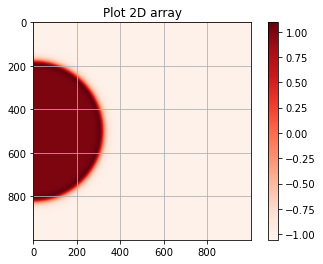

In [26]:
X=U[N-1]

fig = plt.figure()
plt.imshow(X,cmap="Reds")
plt.title("Plot 2D array")
plt.grid()
#plt.xticks(np.arange(0, ny, step=ny/10))
#plt.yticks(np.arange(0, nx, step=nx/10))
plt.colorbar()
plt.show()

In [27]:
der=derivative(U[N-1])
dr=der.dr()
dz=der.dz()
restrain=property(U[N-1],dr,dz)
V=restrain.V()
S=restrain.S()
print(V,S)

1.1589669628940904 6.652445338382865


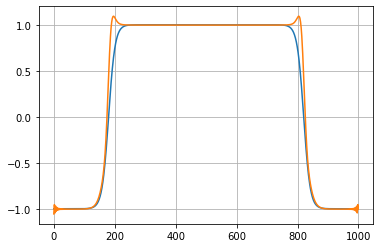

In [28]:
plt.plot(u0[:,0])
plt.plot(U[N-1][:,0])
plt.grid()

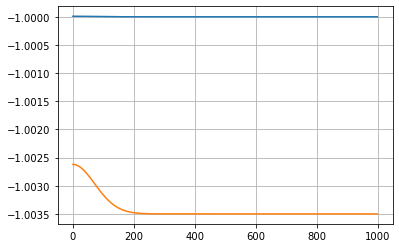

In [29]:
plt.plot(u0[50,:])
plt.plot(U[N-1][50,:])
plt.grid()

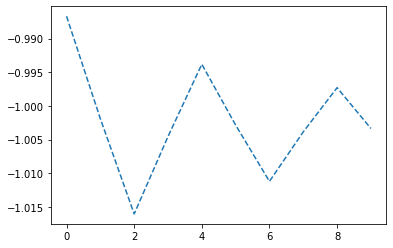

In [30]:
plt.plot(U[N-1][10:20,0],linestyle = "--")

In [31]:
print(np.max(U[N-1]))
print(np.min(U[N-1]))
print(np.max(U[N-1])-np.min(U[N-1])-2)

1.0927582002896794
-1.0558211383928469
0.14857933868252626


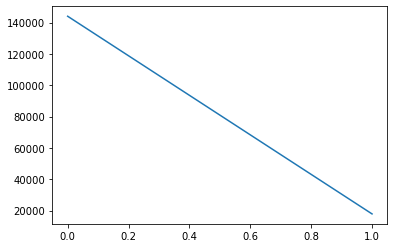

In [32]:
plt.plot(E)

In [33]:
print(E[N-11:N-1])

[144080.6356133715]


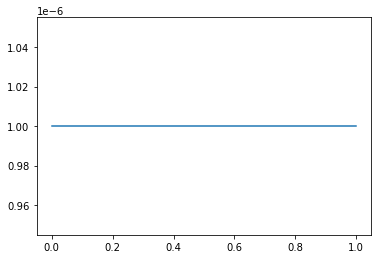

In [34]:
plt.plot(T)

In [35]:
print(T[N-11:N-1])

[1e-06]


In [36]:
print(sum(T))

2e-06


In [37]:
import scipy.stats as stats
print(stats.mode(T))

ModeResult(mode=array([1.e-06]), count=array([2]))
